<a href="https://colab.research.google.com/github/DaoHongDS/ImgCapt_Yolo4_CNN_Obj/blob/main/Yolo4_Trans_conv116_traffic_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mô hình Yolo4 (CNN + Obj)_Trans

Yolo4: conv116 512x169 -> 512x170 -> 170x512

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!cp -av '/content/drive/MyDrive/coco/pycocotools' '/content/'

'/content/drive/MyDrive/coco/pycocotools' -> '/content/pycocotools'
'/content/drive/MyDrive/coco/pycocotools/_mask.pyx' -> '/content/pycocotools/_mask.pyx'
'/content/drive/MyDrive/coco/pycocotools/__init__.py' -> '/content/pycocotools/__init__.py'
'/content/drive/MyDrive/coco/pycocotools/_mask.c' -> '/content/pycocotools/_mask.c'
'/content/drive/MyDrive/coco/pycocotools/_mask.cp39-win_amd64.pyd' -> '/content/pycocotools/_mask.cp39-win_amd64.pyd'
'/content/drive/MyDrive/coco/pycocotools/mask.py' -> '/content/pycocotools/mask.py'
'/content/drive/MyDrive/coco/pycocotools/coco.py' -> '/content/pycocotools/coco.py'
'/content/drive/MyDrive/coco/pycocotools/__pycache__' -> '/content/pycocotools/__pycache__'
'/content/drive/MyDrive/coco/pycocotools/__pycache__/coco.cpython-39.pyc' -> '/content/pycocotools/__pycache__/coco.cpython-39.pyc'
'/content/drive/MyDrive/coco/pycocotools/__pycache__/__init__.cpython-39.pyc' -> '/content/pycocotools/__pycache__/__init__.cpython-39.pyc'
'/content/drive/My

In [ ]:
import os
os.chdir('/content/drive/MyDrive/YOLOv4_CNN_RNN')

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Input
from pycocotools.coco import COCO
import random
from tqdm.notebook import tqdm

import time
import gc

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Path to the images
# IMAGES_PATH = "/content/drive/MyDrive/flick8k/Flicker8k_Dataset"
IMAGES_PATH = "/content/drive/MyDrive/coco/train2014"
IMAGES_CAPS = "/content/drive/MyDrive/coco/annotations/captions_train2014.json"

NUM_FILE =20000

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 35

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 8
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

USE_PRETRAIN = True

In [ ]:
###### Preparing the dataset COCO

def load_captions_data(filename, numFile):
    """Loads captions (text) data and maps them to corresponding images.
    For COCO dataset

    Args:
        filename: Path to the text file containing caption data.
        numFile: number of file (train+val)

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    coco = COCO(filename)
    imgIds = coco.getImgIds()

    # random.Random(seed).shuffle(imgIds)

    imgIds = imgIds[:numFile]


    images = []
    for i in range(len(imgIds)):
        images.append(IMAGES_PATH + '/COCO_train2014_' + '%012d' % (imgIds[i]) + '.jpg')

    captions_mapping = {}
    text_data = []

    for i in range(0,len(images)):
        if images[i] not in captions_mapping:
            annIds = coco.getAnnIds(imgIds = imgIds[i])
            anns = coco.loadAnns(annIds)
            captions = []
            for j in range(0,len(anns)):
                if j < 5:
                    element = '<start> '+ anns[j]['caption'].lower() + ' <end>'
                    captions.append(element)
                    text_data.append(element)
            captions_mapping[images[i]] = captions

    return captions_mapping, text_data


def train_val_split(caption_data, train_size=0.9, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset

captions_mapping, text_data = load_captions_data(IMAGES_CAPS, NUM_FILE)


# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

loading annotations into memory...
Done (t=2.49s)
creating index...
index created!
Number of training samples:  18000
Number of validation samples:  2000


In [ ]:
##### Vectorizing the text data

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)


In [ ]:
### extract combined feature (CNN + Yolo)

from scipy.linalg.decomp import argsort
from IPython.utils.text import indent
import cv2


net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')
scale = 0.00392 #=1/255
layer_names = ['conv_116','yolo_139','yolo_150','yolo_161'] # feature and 3 head layers


def extract_yolo_features(filename):

    image = cv2.imread(str(filename))
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)
    layers = net.forward(layer_names)

    return layers

def extract_combined_feature(filename):
    extracted_layers = extract_yolo_features(filename)

    ####### OBJECTS ###########

    # concat 3 output layers
    out = np.concatenate((extracted_layers[1], extracted_layers[2], extracted_layers[3]), axis = 0)

    ### NMS to get bounding boxes

    image = cv2.imread(filename)
    # Width = image.shape[1]
    # Height = image.shape[0]

    class_ids=[]
    confidences=[]
    p = []
    boxes=[]
    conf_threshold, nms_threshold = 0.5, 0.4

    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id] # prop of class
        if confidence > conf_threshold:
            p.append(detection[4])

            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([detection[0], detection[1], detection[2], detection[3]])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    # print('indices: ', indices)

    bounding_boxes=[]
    important=[]
    for i in range(len(list(indices))):
        # boxes = [x, y, w, h, p, class_ids, important_factor]

        ########## can takeover this 4 position values to save more [class_id, important_factor]
        important_factor = boxes[indices[i]][2] * boxes[indices[i]][3] * confidences[indices[i]]
        important.append(important_factor)

        bbx = boxes[indices[i]].copy()
        bbx.extend([p[indices[i]], class_ids[indices[i]], important_factor])

        bounding_boxes.append(bbx)

    ### sort bounding box to get the most important bounding box first

    ranked = np.argsort(np.array(important))
    largest_indices = ranked[::-1]

    sorted_bbx=[]
    for i in largest_indices:
        b = bounding_boxes[i].copy()
        sorted_bbx.append(b)
    # print('sorted_bbx',sorted_bbx)

    # flattening and padding to fit size of feature vector

    ##### BACKBONE ##########

    backbone_feature = extracted_layers[0] # conv_116: 1x512x13x13
    # print('backbone_feature', backbone_feature.shape)

    backbone_feature = backbone_feature.reshape(backbone_feature.shape[0] * backbone_feature.shape[1], -1) # 512x169
    # print('backbone_feature.shape',backbone_feature.shape) # (512, 169)

    features_shape = backbone_feature.shape[0] # 512

    yolo_features = np.array(sorted_bbx).flatten()
    # print('yolo_features.shape 1', yolo_features.shape)

    # get the first num_of_box to fit the size of feature_shape
    num_of_box = features_shape//7          # choose number of the most important boxes

    yolo_features = yolo_features[:num_of_box*7]
    yolo_features = np.pad(yolo_features, (0, features_shape - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)
    # print('yolo_features.shape 2', yolo_features.shape) # (512,)
    yolo_features = yolo_features.reshape(yolo_features.shape[0], -1)
    # print('yolo_features.shape 3', yolo_features.shape) # (512, 1)

    feature = np.concatenate((backbone_feature, yolo_features), axis=1) #
    feature = np.transpose(feature)
    # print('combined feature shape', feature.shape)

    return feature

<ipython-input-9-b652095e7507>:3: DeprecationWarning: Please use `argsort` from the `scipy.linalg` namespace, the `scipy.linalg.decomp` namespace is deprecated.
  from scipy.linalg.decomp import argsort


In [ ]:
### create .npy feature file

####################################3
#### Do not need when use pretrain
####################################3

if not USE_PRETRAIN:

    FEATURE_DIR = './5_Yolo4_Trans/Yolo4_conv116_npy'
    encode_train = [x for x in list(captions_mapping.keys()) if not os.path.exists(FEATURE_DIR + "/" + x[-31:-4] + ".npy")]

    print("extracting features (" + str(len(encode_train)) + ") file(s)")
    print('len of extracting',len (encode_train))

    if len(encode_train) > 0:
        image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
        image_dataset = image_dataset.batch(16)

        i = 0
        for paths in tqdm(image_dataset):
            for path in paths:
                fn = path.numpy().decode("utf-8")
                combined_feature = extract_combined_feature(fn)
                np.save(FEATURE_DIR + "/" + fn[-31:-4], combined_feature)

                del fn
                del combined_feature

                i += 1
                if(i==500):
                    gc.collect()

    print("\nfinished extracting features")

In [ ]:
# load traffic dataset

TRAFFIC_CAPS = '/content/drive/MyDrive/traffic_data/_caption.txt'
TRAFFIC_IMGS = '/content/drive/MyDrive/traffic_data/_traffic_image_full'

def load_traffic_data(filename):

    caption_mapping = {}
    text_data = []

    with open(filename, encoding='windows-1252') as caption_file:
        caption_data = caption_file.readlines()
        i=0

        for line in caption_data:
            if i>0 :

                line = line.rstrip("\n")
                a = line.split(',')

                img_name = os.path.join(TRAFFIC_IMGS, a[0].strip() +'.jpg')

                sub_a = a[2:]
                caption = " ".join([s.strip() for s in sub_a])
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

            i += 1

        return caption_mapping, text_data

# Load the traffic dataset
traffic_data_dict, traffic_caps = load_traffic_data(TRAFFIC_CAPS)

##### extract traffic features############

TRAFFIC_FEATURES = './5_Yolo4_Trans/Yolo4_conv116_traffImgs_npy'

encode_train = [x for x in list(traffic_data_dict.keys()) if not os.path.exists(TRAFFIC_FEATURES + "/" + x[-12:-4] + ".npy")]

print("extracting traffic features (" + str(len(encode_train)) + ") file(s)")
print('len of extracting',len (encode_train))

if len(encode_train) > 0:
    image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
    image_dataset = image_dataset.batch(16)

    for paths in tqdm(image_dataset):
        for path in paths:
            # print(path)
            fn = path.numpy().decode("utf-8")
            combined_feature = extract_combined_feature(fn)
            np.save(TRAFFIC_FEATURES + "/" + fn[-12:-4], combined_feature)
            del combined_feature

print("\nfinished extracting features")

extracting traffic features (0) file(s)
len of extracting 0

finished extracting features


In [ ]:
from tensorflow.python.ops.gen_logging_ops import image_summary
import sys

### Building a tf.data.Dataset pipeline for training

if not USE_PRETRAIN:

    def process_input(img_path, captions):
        feat = np.load(FEATURE_DIR + '/' + img_path.decode('utf-8')[-31:-4] + '.npy')
        return feat, captions

    def process_caps(item1, item2):
        vect = vectorization(item2)
        return item1, vect

    def _set_shapes(item1, item2):
        item1 = tf.ensure_shape(item1, [170, 512])
        item2 = tf.ensure_shape(item2, [None, SEQ_LENGTH])

        return item1, item2

    def make_dataset(images, captions):

        dataset = tf.data.Dataset.from_tensor_slices((images, captions)) # element: (img_name, [5 caps])
        dataset = dataset.shuffle(BATCH_SIZE * 8)

        dataset = dataset.map(process_caps, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        dataset = dataset.map(lambda item1, item2: tf.numpy_function(func = process_input, inp = [item1, item2], Tout = [tf.float32, tf.int64]),\
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)


        dataset = dataset.map(_set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        return dataset

    # Pass the list of images and the list of corresponding captions
    train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
    valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

    print('valid_dataset', valid_dataset)

In [ ]:
### Building the model

class TransformerEncoderBlock(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)

        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)

        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, encoder, decoder, num_captions_per_image=5
        # self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        # self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

        # self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        # print('loss', loss)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]

        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)

        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

        # print('encoder: ', self.encoder.count_params())
        # print('decoder: ', self.decoder.count_params())

        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # if self.image_aug:
        #     batch_img = self.image_aug(batch_img)

        # # 1. Get image embeddings
        # img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    batch_img, batch_seq[:, i, :], training=True
                    # img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)


        del batch_img
        del batch_seq
        del grads
        del train_vars

        gc.collect()

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        # img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                batch_img, batch_seq[:, i, :], training=False
                # img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


# cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    encoder=encoder,
    decoder=decoder,

    # cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [ ]:
MODEL_DIR = './5_Yolo4_Trans/model_Yolo4_Trans_conv116'

### Model training

if not USE_PRETRAIN:

    # Define the loss function
    cross_entropy = keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction="none"
    )

    # EarlyStopping criteria
    early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


    # Learning Rate Scheduler for the optimizer
    class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, post_warmup_learning_rate, warmup_steps):
            super().__init__()
            self.post_warmup_learning_rate = post_warmup_learning_rate
            self.warmup_steps = warmup_steps

        def __call__(self, step):
            global_step = tf.cast(step, tf.float32)
            warmup_steps = tf.cast(self.warmup_steps, tf.float32)
            warmup_progress = global_step / warmup_steps
            warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
            return tf.cond(
                global_step < warmup_steps,
                lambda: warmup_learning_rate,
                lambda: self.post_warmup_learning_rate,
            )


    # Create a learning rate schedule
    num_train_steps = len(train_dataset) * EPOCHS
    num_warmup_steps = num_train_steps // 15
    lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

    # Compile the model

    caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

    # Fit the model
    t1 = time.time()
    caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        # validation_data=valid_dataset,
        # callbacks=[early_stopping],
    )
    t2 = time.time()

    print('\nTime of training for {0:2d} epochs: {1:.2f} seconds'.format(EPOCHS, t2-t1))

    # caption_model.save_weights(MODEL_DIR + "/my_Yolo_trans_model" , save_format="tf")

else:
    print('use pretrain weights')
    caption_model.load_weights(MODEL_DIR + "/my_Yolo_trans_model")

use pretrain weights


sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00005684.jpg
actual capts:  ['<start> Many vehicles are moving on the right side of the road divider. <end>', '<start> On the right side of the road divider there are a lot of vehicles traveling. <end>', '<start> Plenty of vehicles are moving along the right side of the road divider. <end>', '<start> A number of vehicles are proceeding along the right side of the road divider which has some trees planted on. <end>', '<start> A lot of vehicles are going on the right side of the road divider. <end>']
Predicted Caption:  a red and white bus driving down a street


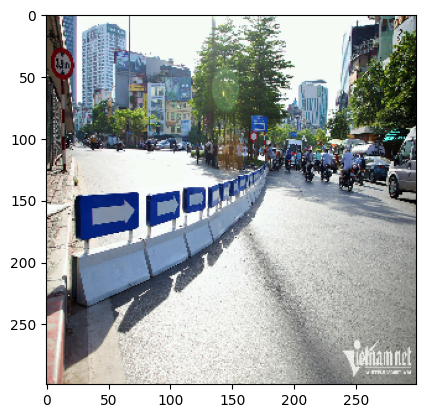

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00008306.jpg
actual capts:  ['<start> The white car is in front of the toll station at the center of the road. <end>', '<start> In front of the left side of the toll station there is a car. <end>', '<start> The white car is on the left side at the toll station. <end>', '<start> The car is parked in front of the toll station. <end>', '<start> At the toll station there is a white car. <end>']
Predicted Caption:  a bus driving down a street with a red bus


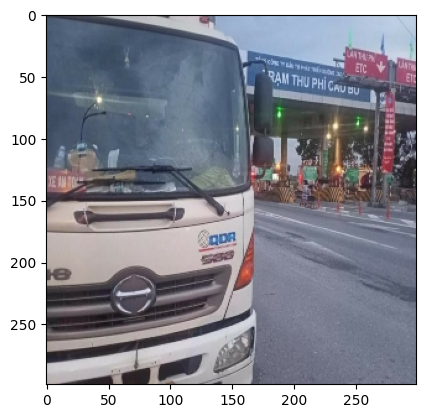

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00002094.jpg
actual capts:  ['<start> There are a large number of cars on the street. <end>', '<start> Many motorcycles are on the left side of the street. <end>', '<start> There is a red car in traffic. <end>', '<start> The green motorcycle are on the left side of the road. <end>', '<start> There are some motorcycles on the right side of the two white cars. <end>']
Predicted Caption:  a group of people riding bikes down a street


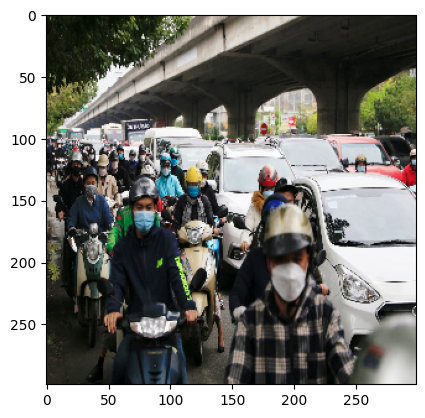

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00010260.jpg
actual capts:  ['<start> Three motorcycles are reaching the crosswalk. <end>', '<start> There are three motorcycles approaching the crosswalk. <end>', '<start> Three people are riding motorcycles to come to the crosswalk. <end>', '<start> There is a motorcycle going on the crosswalk. <end>', '<start> A person is riding a motorcycle on the crosswalk. <end>']
Predicted Caption:  a group of people riding motorcycles down the street


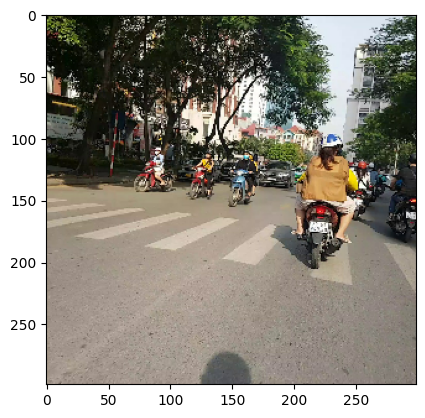

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00007450.jpg
actual capts:  ['<start> Three cars are proceeding along the road. <end>', '<start> On the road there are three cars moving. <end>', '<start> There is a car going along the left side of the road. <end>', '<start> On the middle of the road two cars are moving in a line. <end>', '<start> Two cars are following each other on the middle of the road. <end>']
Predicted Caption:  a red truck driving down a street next to a car


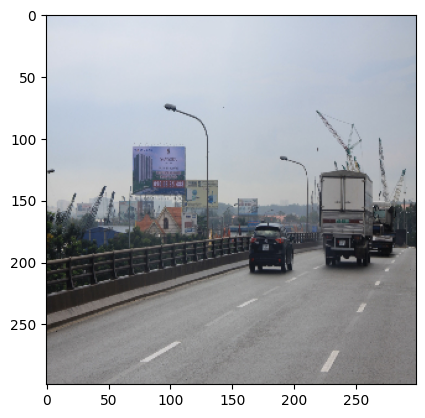

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00009986.jpg
actual capts:  ['<start> The woman is riding a motorcycle along the middle of the road. <end>', '<start> A number of motorcycles are moving on the road. <end>', '<start> Some motorcycles are following each other on the middle of the road. <end>', '<start> There is a line of motorcycles moving along the center of the road. <end>', '<start> On the road a number of people are riding motorcycles. <end>']
Predicted Caption:  a man riding a motorcycle down a street


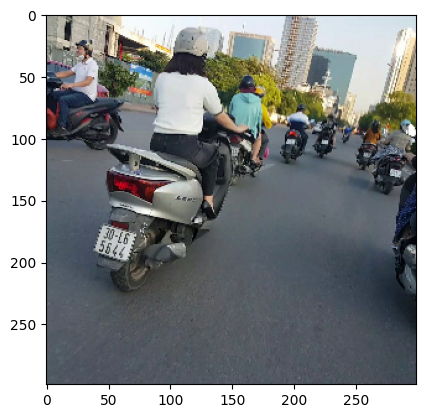

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00008241.jpg
actual capts:  ['<start> Two cars are moving through the lane of the toll station. <end>', '<start> The blue car is in front of a white car in the toll station. <end>', '<start> In the toll station there is a white car behind the blue car. <end>', '<start> The white car and the blue one are going through the toll station. <end>', '<start> The two cars are traveling through the toll station. <end>']
Predicted Caption:  a car parked next to a street with a woman on it


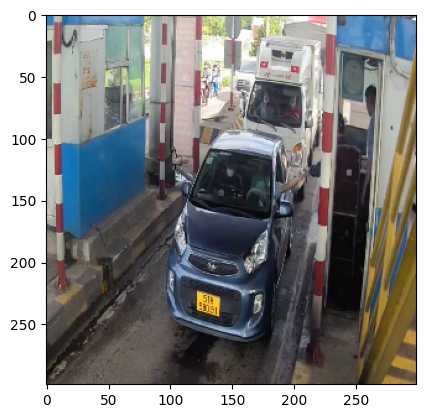

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00006436.jpg
actual capts:  ['<start> There is a bus on the right side of the road. <end>', '<start> There is a blue bus. <end>', '<start> The blue bus is moving along the right side of the road. <end>', '<start> The bus is proceeding along the road. <end>', '<start> The color of the bus moving on the road is blue. <end>']
Predicted Caption:  a group of people riding bikes down a street


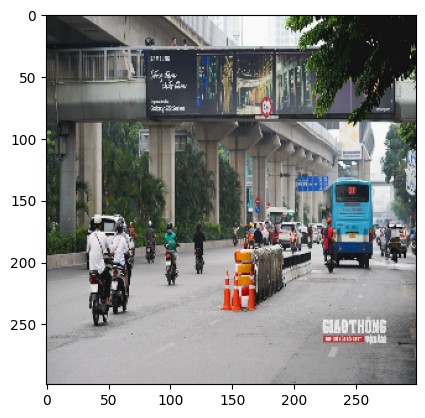

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00006484.jpg
actual capts:  ['<start> There are lots of signposts on the road. <end>', '<start> There are three signposts hung up on the center of the road. <end>', '<start> There is a signpost put on the left side of the road. <end>', '<start> On the right side of the road there is a signpost. <end>', '<start> Many signposts have been arranged on this stretch of the road. <end>']
Predicted Caption:  a street scene of a city street with a lot of people on the street


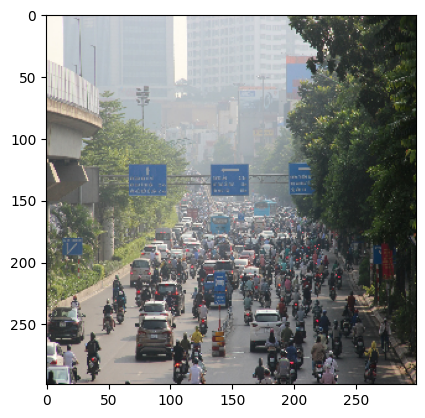

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00003893.jpg
actual capts:  ['<start> There is a traffic jam on the one-way street. <end>', '<start> The traffic jam is happening on the one-way street. <end>', '<start> The situation of traffic jam is occurring on the one-way street. <end>', '<start> The traffic jam is happening on the one-way street which is packed full of vehicles. <end>', '<start> There is a traffic jam happening on the one-way street which is packed full of vehicles. <end>']
Predicted Caption:  a street scene of a city street with a lot of cars and a motorcycle


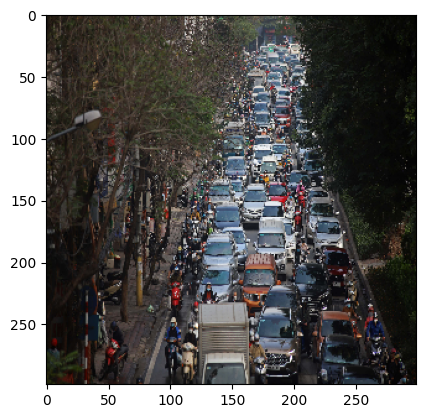

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00010190.jpg
actual capts:  ['<start> The bus is proceeding along the middle of the road. <end>', '<start> There is a bus moving along the middle of the road. <end>', '<start> On the center of the road there is a bus traveling. <end>', '<start> A bus is in motion on the center of the road. <end>', '<start> On the road there is a bus on the move. <end>']
Predicted Caption:  a man riding a motorcycle down the street


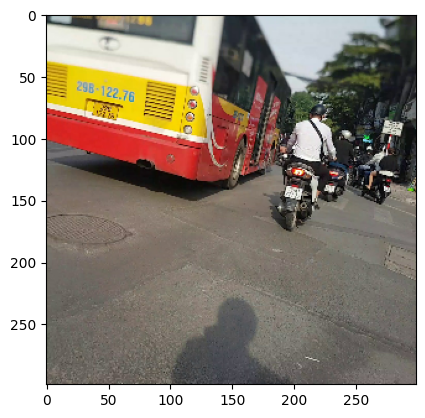

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00009972.jpg
actual capts:  ['<start> A number of motorcycles are moving along the middle of the road. <end>', '<start> There are some people riding motorcycles on the middle of the road. <end>', '<start> The red motorcycle is going along the right side of the road. <end>', '<start> On the middle of the road several motorcycles are moving about. <end>', '<start> There are a number of motorcycles in motion on the road. <end>']
Predicted Caption:  a group of people on motorcycles riding down a street


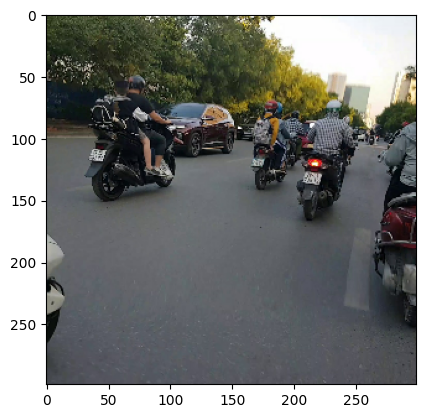

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00010126.jpg
actual capts:  ['<start> There are two moving motorbikes. <end>', '<start> Two motorbikes are going. <end>', '<start> Two people are riding motorbikes. <end>', '<start> Motorbikes are traveling. <end>', '<start> There are two motorbikes in motion. <end>']
Predicted Caption:  a group of people riding motorcycles down a street


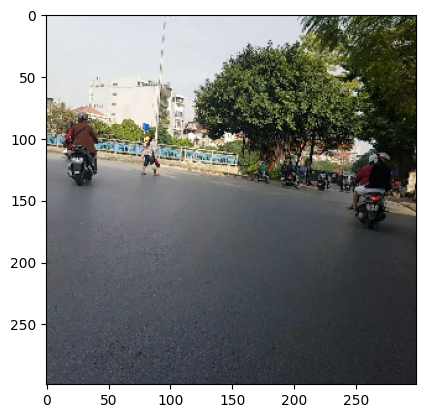

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00010142.jpg
actual capts:  ['<start> The woman in a sun shirt is riding a motorcycle. <end>', '<start> There is a woman in a blue sun shirt riding a motorcycle. <end>', '<start> There is a red motorcycle on the move. <end>', '<start> A few motorcycles are in traffic. <end>', '<start> Five motorcycles are traveling. <end>']
Predicted Caption:  a man riding a motorcycle down a street


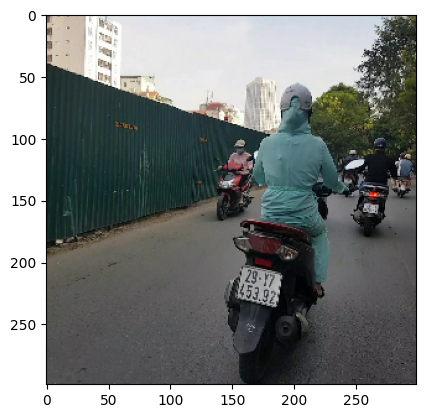

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00010137.jpg
actual capts:  ['<start> There are two red motorcycles. <end>', '<start> Two red motorcycles are in traffic. <end>', '<start> There are several motorcycles. <end>', '<start> On the street there are some motorcycles. <end>', '<start> Among the motorcycles on the street there are two red motorcycles. <end>']
Predicted Caption:  a young boy is riding a motorcycle down a street


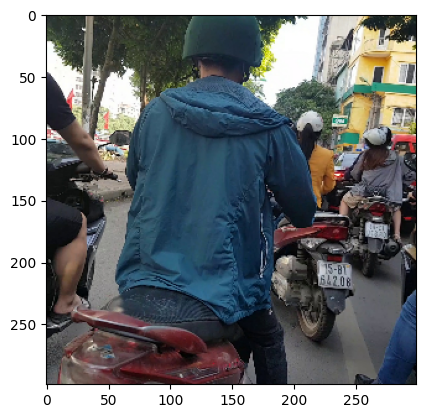

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00003258.jpg
actual capts:  ['<start> There is a car on the right roadside. <end>', '<start> There is a car parked on the roadside. <end>', '<start> The car is on the right roadside. <end>', '<start> The car is stopped on the right roadside. <end>', '<start> The car is parked on the right roadside in front of the white gate. <end>']
Predicted Caption:  a red fire truck driving down a street


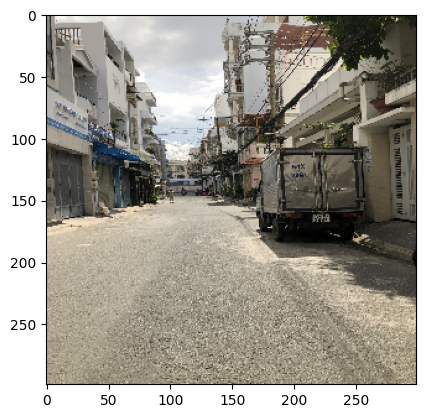

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00004021.jpg
actual capts:  ['<start> There is a taxi on the road. <end>', '<start> There are some cars around a green taxi on the road. <end>', '<start> There are some cars on the road. <end>', '<start> The green taxi is in the middle of cars on the road. <end>', '<start> There are a green taxi and some cars on the road. <end>']
Predicted Caption:  a group of people walking down a street


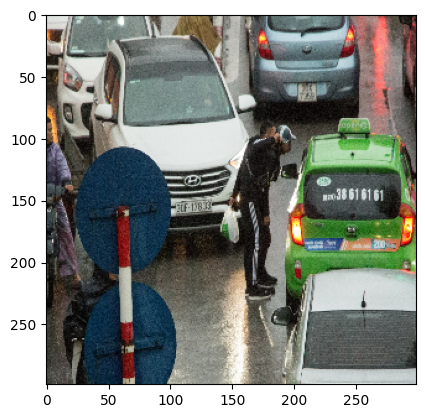

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00009859.jpg
actual capts:  ['<start> The motorbike is moving behind the red car on the road. <end>', '<start> The red car is traveling in front of a motorbike on the road. <end>', '<start> The black motorbike is circulating behind a red car on the road. <end>', '<start> There is a red car in motion in front of a black motorbike on the road. <end>', '<start> A motorbike and a red car are traveling on the road. <end>']
Predicted Caption:  a person riding a motorcycle down a street


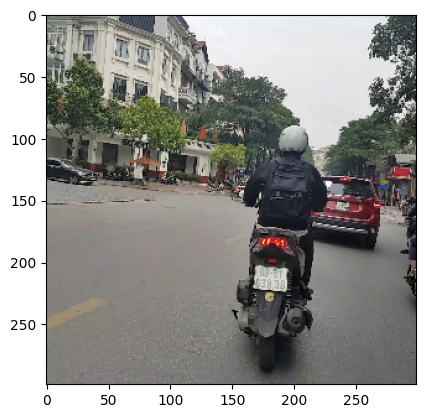

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00006834.jpg
actual capts:  ['<start> Cars and motorcycles are crowded together on the road. <end>', '<start> On the road motorcycles and cars are closely packed. <end>', '<start> The route is congested with motorcycles and cars. <end>', '<start> On the road cars and motorcycles are crammed together. <end>', '<start> There are an enormous number of motorcycles and cars circulating on the road. <end>']
Predicted Caption:  a group of people riding bikes down a street


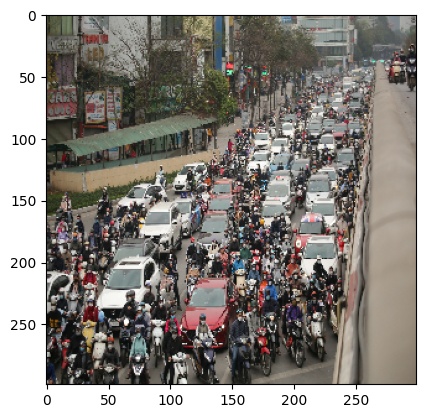

sample_img:  /content/drive/MyDrive/traffic_data/_traffic_image_full/00009660.jpg
actual capts:  ['<start> A car and some motorcycles are moving on the middle of the road. <end>', '<start> On the center of the road some motorcycles and a car are in motion. <end>', '<start> The black car and several motorcycles are on the move on the center of the road. <end>', '<start> There are some motorcycles going behind the black car on the middle of the road. <end>', '<start> The black car is circulating in front of several motorcycles on the road. <end>']
Predicted Caption:  a person riding a motorcycle down a street


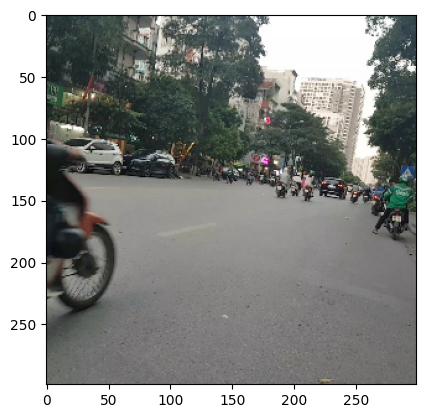

In [ ]:
### Check sample predictions

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def decode_and_resize(img_path):
    # print('img_path', img_path)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def generate_caption(sample_img):
    img = np.load(TRAFFIC_FEATURES + '/' + sample_img[-12:-4] + '.npy')
    img = np.expand_dims(img, 0)
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption


list_name = [
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00005684.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00008306.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00002094.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00010260.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00007450.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00009986.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00008241.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00006436.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00006484.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00003893.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00010190.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00009972.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00010126.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00010142.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00010137.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00003258.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00004021.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00009859.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00006834.jpg',
    '/content/drive/MyDrive/traffic_data/_traffic_image_full/00009660.jpg'

]

# Check predictions for a few samples
for sample_img in list_name:
    # Select a random image from the traffic_data_dict dataset
    # sample_img = np.random.choice(traffic_img_list)


    print('sample_img: ', sample_img)
    print('actual capts: ', traffic_data_dict[sample_img])
    print('Predicted Caption: ', generate_caption(sample_img))

    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [ ]:
# evaluate the model
##############################
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# evaluate the skill of the model
def evaluate_model():
    actual, predicted = list(), list()

    # step over the whole set
    for key, desc_list in tqdm(traffic_data_dict.items()):
        # generate description
        yhat = generate_caption(key)

        # references = [d.split() for d in desc_list]
        references = []
        for cap in desc_list:
            tmp = cap.replace('<start> ', '').replace(' <end>', '').replace('.','').lower()
            references.append(tmp.split())

        actual.append(references)
        predicted.append(yhat.split())

        # print('actual', actual)
        # print('predicted', predicted)

	# calculate BLEU score
    bl1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bl2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bl3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bl4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    print('BLEU-1: %f' % bl1)
    print('BLEU-2: %f' % bl2)
    print('BLEU-3: %f' % bl3)
    print('BLEU-4: %f' % bl4)

    # meteor score
    mt = 0
    for i in range(len(predicted)):
        mt += round(meteor_score(actual[i], predicted[i]),4)
    mt = mt/len(predicted)
    print('METEOR: %f' % mt)


# evaluate model
evaluate_model()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  0%|          | 0/3094 [00:00<?, ?it/s]

BLEU-1: 0.316189
BLEU-2: 0.139451
BLEU-3: 0.087946
BLEU-4: 0.033569
METEOR: 0.164516
